Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'F:/NLP/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
      # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

      # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

      # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
                        + beta_regul * tf.nn.l2_loss(weights)

      # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regul:1e-3}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.666914
Minibatch accuracy: 11.7%
Validation accuracy: 13.5%
Minibatch loss at step 500: 2.276793
Minibatch accuracy: 82.8%
Validation accuracy: 75.9%
Minibatch loss at step 1000: 1.708365
Minibatch accuracy: 82.0%
Validation accuracy: 78.2%
Minibatch loss at step 1500: 0.956839
Minibatch accuracy: 85.2%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 0.775458
Minibatch accuracy: 88.3%
Validation accuracy: 80.5%
Minibatch loss at step 2500: 0.828236
Minibatch accuracy: 79.7%
Validation accuracy: 81.7%
Minibatch loss at step 3000: 0.775532
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Test accuracy: 89.0%


+ 这里的beta_regul选择的是1e-3，看一下是否有更好的值

In [15]:
num_steps = 3001
regul_val = [pow(10,i) for i in np.arange(-4,-2,0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regul:regul}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(),test_labels))

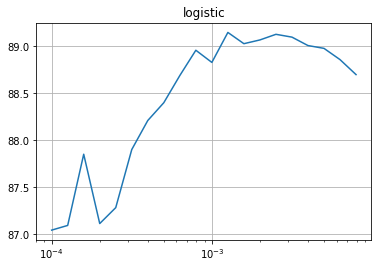

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(regul_val,accuracy_val)
plt.grid(True)
plt.title('logistic')
plt.show()

+ 1-hidden layer neural network

In [36]:
batch_size = 128
num_hidden_node = 1024

graph = tf.Graph()
with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

      # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_node]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_node]))
    
    #
    weights_2 = tf.Variable(
        tf.truncated_normal([num_hidden_node,num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    

      # Training computation.
    lay_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    logits = tf.matmul(lay_train, weights_2) + biases_2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
         beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) )       

      # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(lay_valid, weights_2) + biases_2)
    
    lay_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(tf.matmul(lay_test, weights_2) + biases_2)

In [37]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regul:1e-3}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 676.471802
Minibatch accuracy: 8.6%
Validation accuracy: 37.7%
Minibatch loss at step 500: 198.382141
Minibatch accuracy: 80.5%
Validation accuracy: 79.4%
Minibatch loss at step 1000: 114.970322
Minibatch accuracy: 77.3%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 68.790100
Minibatch accuracy: 86.7%
Validation accuracy: 83.1%
Minibatch loss at step 2000: 41.323761
Minibatch accuracy: 89.8%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 25.156862
Minibatch accuracy: 88.3%
Validation accuracy: 85.6%
Minibatch loss at step 3000: 15.484298
Minibatch accuracy: 88.3%
Validation accuracy: 86.3%
Test accuracy: 93.0%


In [25]:
num_steps = 3001
regul_val = [pow(10,i) for i in np.arange(-4,-2,0.1)]
accuracy_val_neural = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regul:regul}
            _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val_neural.append(accuracy(test_prediction.eval(),test_labels))

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(regul_val,accuracy_val_neural)
plt.grid(True)
plt.title('logistic')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [26]:
batch_size = 128
num_hidden_node = 1024

graph = tf.Graph()
with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

      # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_node]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_node]))
    
    #
    weights_2 = tf.Variable(
        tf.truncated_normal([num_hidden_node,num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    

      # Training computation.
    lay_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    logits = tf.matmul(lay_train, weights_2) + biases_2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))        

      # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(lay_valid, weights_2) + biases_2)
    
    lay_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(tf.matmul(lay_test, weights_2) + biases_2)

In [27]:
num_steps = 101
num_branch = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = ((step % num_branch) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regul:1e-3}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 5 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 365.148041
Minibatch accuracy: 10.2%
Validation accuracy: 29.5%
Minibatch loss at step 5: 102.823334
Minibatch accuracy: 73.4%
Validation accuracy: 63.8%
Minibatch loss at step 10: 53.578259
Minibatch accuracy: 85.9%
Validation accuracy: 70.3%
Minibatch loss at step 15: 19.859257
Minibatch accuracy: 91.4%
Validation accuracy: 73.5%
Minibatch loss at step 20: 1.410985
Minibatch accuracy: 98.4%
Validation accuracy: 74.6%
Minibatch loss at step 25: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 30: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 35: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 45: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 50: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [28]:
batch_size = 128
num_hidden_node = 1024

graph = tf.Graph()
with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

      # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_node]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_node]))
    
    #
    weights_2 = tf.Variable(
        tf.truncated_normal([num_hidden_node,num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    

      # Training computation.
    lay_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    drop1 = tf.nn.dropout(lay_train,0.5)
    logits = tf.matmul(drop1, weights_2) + biases_2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))        

      # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_prediction = tf.nn.softmax(
        tf.matmul(lay_valid, weights_2) + biases_2)
    
    lay_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(tf.matmul(lay_test, weights_2) + biases_2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
num_steps = 101
num_branch = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = step % num_branch
        offset = ((step % num_branch) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 464.023682
Minibatch accuracy: 15.6%
Validation accuracy: 20.0%
Minibatch loss at step 2: 1298.329224
Minibatch accuracy: 41.4%
Validation accuracy: 26.6%
Minibatch loss at step 4: 642.012634
Minibatch accuracy: 48.4%
Validation accuracy: 51.0%
Minibatch loss at step 6: 394.419495
Minibatch accuracy: 54.7%
Validation accuracy: 59.5%
Minibatch loss at step 8: 33.013435
Minibatch accuracy: 85.9%
Validation accuracy: 74.5%
Minibatch loss at step 10: 46.336048
Minibatch accuracy: 84.4%
Validation accuracy: 74.7%
Minibatch loss at step 12: 47.496021
Minibatch accuracy: 82.0%
Validation accuracy: 72.2%
Minibatch loss at step 14: 17.548189
Minibatch accuracy: 88.3%
Validation accuracy: 73.9%
Minibatch loss at step 16: 12.404629
Minibatch accuracy: 92.2%
Validation accuracy: 75.1%
Minibatch loss at step 18: 23.812737
Minibatch accuracy: 92.2%
Validation accuracy: 74.5%
Minibatch loss at step 20: 11.893568
Minibatch accuracy: 93.8%
Validation accuracy: 74.8

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


+ 两层神经网络

In [33]:
batch_size = 128
num_hidden_node1 = 1024
num_hidden_node2 = 256
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

      # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_node1],stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases_1 = tf.Variable(tf.zeros([num_hidden_node1]))
    
    weights_2 = tf.Variable(
        tf.truncated_normal([num_hidden_node1,num_hidden_node2],stddev=np.sqrt(2.0 / num_hidden_node1)))
    biases_2 = tf.Variable(tf.zeros([num_hidden_node2]))
    
    weights_3 = tf.Variable(
        tf.truncated_normal([num_hidden_node2,num_labels],stddev=np.sqrt(2.0 / num_hidden_node2)))
    biases_3 = tf.Variable(tf.zeros([num_labels]))
    

      # Training computation.
    lay_train1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    lay_train2 = tf.nn.relu(tf.matmul(lay_train1, weights_2) + biases_2)
    logits = tf.matmul(lay_train2, weights_3) + biases_3
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3))

      # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5,global_step,1000,0.65,staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay_valid1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    lay_valid2 = tf.nn.relu(tf.matmul(lay_valid1, weights_2) + biases_2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay_valid2, weights_3) + biases_3)
    
    lay_test1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    lay_test2 = tf.nn.relu(tf.matmul(lay_test1, weights_2) + biases_2)
    test_prediction = tf.nn.softmax(tf.matmul(lay_test2, weights_3) + biases_3)

In [34]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.356025
Minibatch accuracy: 10.9%
Validation accuracy: 37.2%
Minibatch loss at step 500: 1.001440
Minibatch accuracy: 89.8%
Validation accuracy: 86.0%
Minibatch loss at step 1000: 0.912210
Minibatch accuracy: 84.4%
Validation accuracy: 86.6%
Minibatch loss at step 1500: 0.602747
Minibatch accuracy: 93.0%
Validation accuracy: 88.2%
Minibatch loss at step 2000: 0.531688
Minibatch accuracy: 94.5%
Validation accuracy: 88.2%


KeyboardInterrupt: 

+ 三层网络

In [35]:
batch_size = 128
num_hidden_node1 = 1024
num_hidden_node2 = 256
num_hidden_node3 = 128
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                        shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

      # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_node1],stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases_1 = tf.Variable(tf.zeros([num_hidden_node1]))
    
    weights_2 = tf.Variable(
        tf.truncated_normal([num_hidden_node1,num_hidden_node2],stddev=np.sqrt(2.0 / num_hidden_node1)))
    biases_2 = tf.Variable(tf.zeros([num_hidden_node2]))
    
    weights_3 = tf.Variable(
        tf.truncated_normal([num_hidden_node2,num_hidden_node3],stddev=np.sqrt(2.0 / num_hidden_node2)))
    biases_3 = tf.Variable(tf.zeros([num_hidden_node3]))
    weights_4 = tf.Variable(
        tf.truncated_normal([num_hidden_node3,num_labels],stddev=np.sqrt(2.0 / num_hidden_node3)))
    biases_4 = tf.Variable(tf.zeros([num_labels]))
    

      # Training computation.
    lay_train1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    lay_train2 = tf.nn.relu(tf.matmul(lay_train1, weights_2) + biases_2)
    lay_train3 = tf.nn.relu(tf.matmul(lay_train2, weights_3) + biases_3)
    logits = tf.matmul(lay_train3, weights_4) + biases_4
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4))

      # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5,global_step,4000,0.65,staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)

      # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    lay_valid1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    lay_valid2 = tf.nn.relu(tf.matmul(lay_valid1, weights_2) + biases_2)
    lay_valid3 = tf.nn.relu(tf.matmul(lay_valid2, weights_3) + biases_3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay_valid3, weights_4) + biases_4)
    
    lay_test1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    lay_test2 = tf.nn.relu(tf.matmul(lay_test1, weights_2) + biases_2)
    lay_test3 = tf.nn.relu(tf.matmul(lay_test2, weights_3) + biases_3)
    test_prediction = tf.nn.softmax(tf.matmul(lay_test3, weights_4) + biases_4)

In [ ]:
num_steps = 9001 ##可以增大

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))